In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image


In [50]:
!tar -xf "/content/drive/MyDrive/Grad/AffectNet/train_images.tar" -C "/"
# !tar -xf "/content/drive/MyDrive/Grad/AffectNet/val_images.tar" -C "/"

In [27]:
class AffectNet(Dataset):
    def __init__(self, annotations_file, root_dir, transform=None, target_transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = read_image(img_path)
        labels = self.annotations.iloc[idx, 1:]
        labels = labels.to_numpy()
        labels = torch.from_numpy(labels.astype('float'))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)
        return image, labels

In [28]:
val_path = "/content/drive/MyDrive/Grad/AffectNet/val_annotations.csv"
root_dir = "/content/val_set/images"

val_set = AffectNet(val_path, root_dir)
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=True)

In [14]:
#!unzip "/content/drive/MyDrive/Grad/AffectNet-8Labels.zip" -d "./dataset"
#!tar -xf "/content/dataset/val_set.tar" -C "/content/dataset"

In [47]:
torch.manual_seed(42)
features, labels = next(iter(val_dataloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
img = features[0].squeeze()
label = labels[0]

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32, 3])


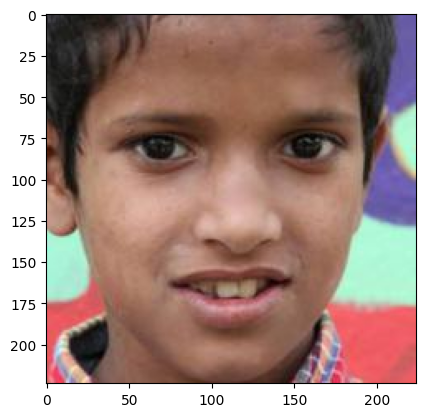

aro: tensor([ 0.6032, -0.6349,  7.0000], dtype=torch.float64)


In [48]:
import matplotlib.pyplot as plt

plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"aro: {label}")

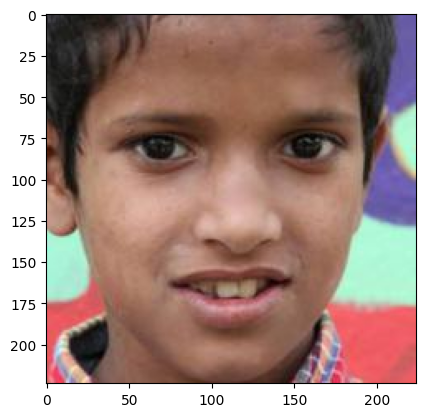

aro: tensor([ 0.6032, -0.6349,  7.0000], dtype=torch.float64)


In [46]:
original = "/content/dataset/val_set/images/678.jpg"
orim = read_image(original)
aro = torch.from_numpy(np.load("/content/dataset/val_set/annotations/678_aro.npy").astype('float'))
val = torch.from_numpy(np.load("/content/dataset/val_set/annotations/678_val.npy").astype('float'))
exp = torch.from_numpy(np.load("/content/dataset/val_set/annotations/678_exp.npy").astype('float'))
t = torch.concat([aro.unsqueeze(0), val.unsqueeze(0), exp.unsqueeze(0)])
plt.imshow(orim.permute(1, 2, 0))
plt.show()
print(f"aro: {t}")

In [49]:
val_df = pd.read_csv("/content/drive/MyDrive/Grad/val_annotations.csv")
val_df.head()


,id,arousal,valance,expression
0,1943.jpg,0.769454,-0.067751,4
1,4717.jpg,-0.245859,-0.651311,2
2,4054.jpg,0.504263,-0.758994,5
3,3855.jpg,0.740418,0.295199,3
4,536.jpg,0.253968,-0.555556,6


In [51]:
train_df = pd.read_csv("/content/drive/MyDrive/Grad/train_annotations.csv")
val_df.head()

,id,arousal,valance,expression
0,1943.jpg,0.769454,-0.067751,4
1,4717.jpg,-0.245859,-0.651311,2
2,4054.jpg,0.504263,-0.758994,5
3,3855.jpg,0.740418,0.295199,3
4,536.jpg,0.253968,-0.555556,6


In [57]:
merge_df = pd.concat([train_df, val_df])
merge_df.head()

,id,arousal,valance,expression
0,212103.jpg,-0.007937,0.015873,0
1,318520.jpg,0.079014,0.489886,1
2,19023.jpg,0.643631,-0.425861,3
3,94739.jpg,0.147493,0.510957,1
4,33548.jpg,-0.060387,0.681504,1


In [102]:
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transforms(read_image(original))

tensor([[[-0.3541, -0.3541, -0.3369,  ..., -1.2959, -1.1075, -0.8849],
         [-0.3712, -0.3712, -0.3541,  ..., -1.1932, -1.0219, -1.0562],
         [-0.3883, -0.3712, -0.3712,  ..., -1.1418, -1.0219, -1.3987],
         ...,
         [ 2.0605,  2.0605,  2.0263,  ...,  2.1804,  1.7523,  1.3242],
         [ 2.0777,  2.0434,  2.0263,  ...,  1.9235,  1.4954,  1.2385],
         [ 2.0777,  2.0605,  2.0092,  ...,  1.7180,  1.3413,  1.2385]],

        [[-0.4601, -0.4601, -0.4251,  ..., -1.2129, -1.0203, -0.7927],
         [-0.4776, -0.4776, -0.4426,  ..., -1.1078, -0.9328, -0.9678],
         [-0.4951, -0.4776, -0.4601,  ..., -1.0553, -0.9328, -1.3179],
         ...,
         [-0.4076, -0.4076, -0.4076,  ...,  0.3102, -0.0049, -0.3550],
         [-0.4251, -0.4251, -0.4076,  ...,  0.2577,  0.0126, -0.1800],
         [-0.4251, -0.4426, -0.4251,  ...,  0.1352, -0.0224, -0.0224]],

        [[ 1.1585,  1.1585,  1.1237,  ..., -0.8807, -0.6890, -0.4624],
         [ 1.1411,  1.1411,  1.1062,  ..., -0